In [1]:
import transformers
import accelerate
import peft
import wandb
import os


print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")
print(f"PEFT version: {peft.__version__}")

Transformers version: 4.38.2
Accelerate version: 0.27.2
PEFT version: 0.9.0


In [25]:
!pwd

/baie/nfs-cluster-1/mundus/abhowmik697/DepthAnything/scripts


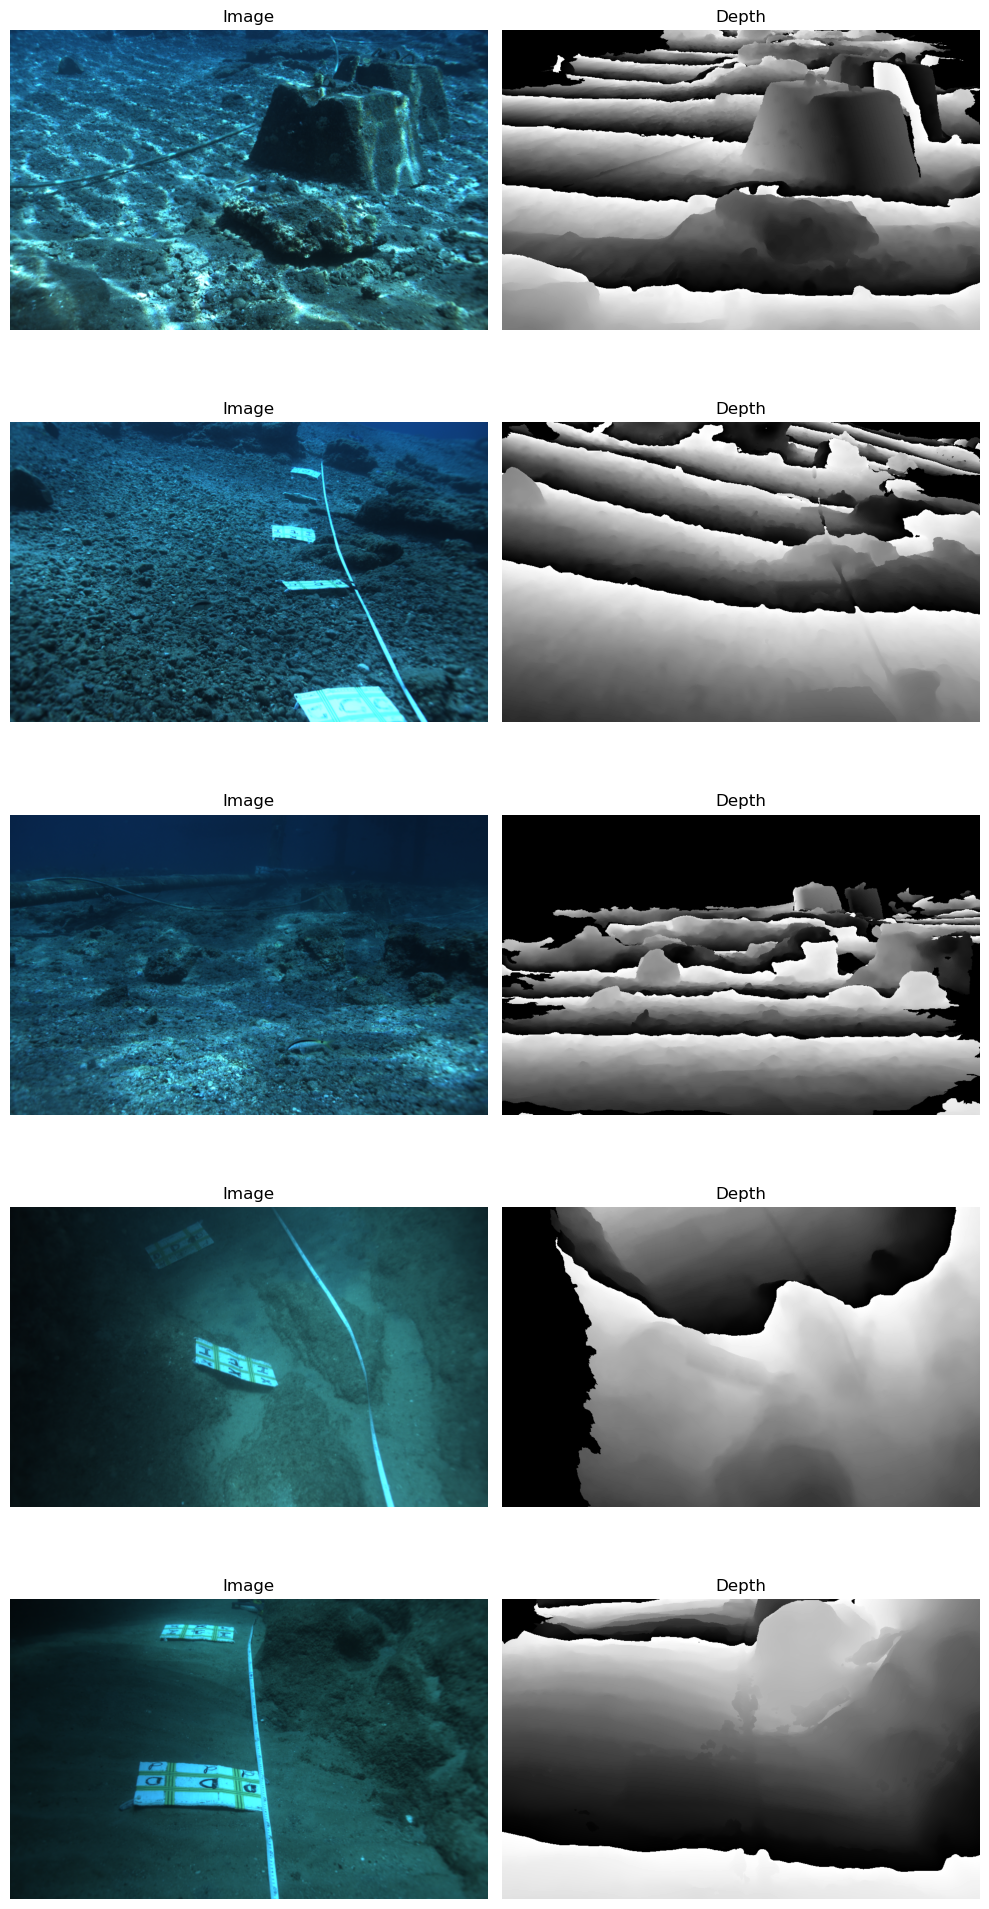

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = self._load_data()

    def _load_data(self):
        data = []
        for root, _, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith('.tif'):
                    if 'depth' in root:
                        depth_path = os.path.join(root, file)
                        image_path = os.path.join(root.replace('depth', 'imgs'), file.replace('_SeaErra_abs_depth.tif', '.tiff'))
                        data.append((image_path, depth_path))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, depth_path = self.data[idx]
        image = Image.open(image_path)
        depth = Image.open(depth_path)
        if self.transform:
            image = self.transform(image)
            depth = self.transform(depth)
        return image, depth

# Example usage
transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = CustomDataset(root_dir='/mundus/abhowmik697/FLSea_Dataset', transform=transform)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

batch = next(iter(dataloader))

images, depths = batch

fig, axes = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    image = transforms.ToPILImage()(images[i])
    depth = transforms.ToPILImage()(depths[i])

    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(depth, cmap='gray')
    axes[i, 1].set_title('Depth')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [3]:
len(dataset)

22451

In [5]:
dataset[:1000]

ValueError: too many values to unpack (expected 2)

In [5]:
from huggingface_hub import notebook_login

notebook_login()

In [8]:
model_checkpoint = "LiheYoung/depth-anything-small-hf"

In [9]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

In [10]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

#normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

data_transforms = Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        #normalize,
    ]
)


In [20]:
dataset = CustomDataset(root_dir='/mundus/abhowmik697/FLSea_Dataset', transform=data_transforms)

train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])


In [23]:
training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)

In [12]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [13]:
from transformers import AutoModelForDepthEstimation, TrainingArguments, Trainer

model = AutoModelForDepthEstimation.from_pretrained(
    model_checkpoint,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

In [14]:
print_trainable_parameters(model)

trainable params: 24785089 || all params: 24785089 || trainable%: 100.00


In [45]:
from peft import LoraConfig, get_peft_model

peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="lora_only",
    modules_to_save=["decode_head"],
)
lora_model = get_peft_model(model, peft_config)
print_trainable_parameters(lora_model)

trainable params: 294912 || all params: 25080001 || trainable%: 1.18


In [46]:
for name, param in lora_model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

base_model.model.base_model.model.backbone.encoder.layer.0.attention.attention.query.lora_A.default.weight torch.Size([16, 384])
base_model.model.base_model.model.backbone.encoder.layer.0.attention.attention.query.lora_B.default.weight torch.Size([384, 16])
base_model.model.base_model.model.backbone.encoder.layer.0.attention.attention.value.lora_A.default.weight torch.Size([16, 384])
base_model.model.base_model.model.backbone.encoder.layer.0.attention.attention.value.lora_B.default.weight torch.Size([384, 16])
base_model.model.base_model.model.backbone.encoder.layer.1.attention.attention.query.lora_A.default.weight torch.Size([16, 384])
base_model.model.base_model.model.backbone.encoder.layer.1.attention.attention.query.lora_B.default.weight torch.Size([384, 16])
base_model.model.base_model.model.backbone.encoder.layer.1.attention.attention.value.lora_A.default.weight torch.Size([16, 384])
base_model.model.base_model.model.backbone.encoder.layer.1.attention.attention.value.lora_B.defau

In [18]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def scale_offset_invariance_psnr(depth_map1, depth_map2):
    # Calculate the mean value of both depth maps
    mean1 = np.mean(depth_map1)
    mean2 = np.mean(depth_map2)

    # Calculate the scale factor
    scale_factor = mean1 / mean2

    # Adjust the second depth map by the scale factor
    depth_map2_scaled = depth_map2 * scale_factor

    # Calculate the offset
    offset = mean1 - (scale_factor * mean2)

    # Adjust the second depth map by the offset
    depth_map2_adjusted = depth_map2_scaled + offset


    #Calculate the PSNR
    psnr_val = psnr(depth_map1, depth_map2_adjusted)

    return psnr_val


def scale_offset_invariance_ssim(depth_map1, depth_map2):
    # Calculate the mean value of both depth maps
    mean1 = np.mean(depth_map1)
    mean2 = np.mean(depth_map2)

    # Calculate the scale factor
    scale_factor = mean1 / mean2

    # Adjust the second depth map by the scale factor
    depth_map2_scaled = depth_map2 * scale_factor

    # Calculate the offset
    offset = mean1 - (scale_factor * mean2)

    # Adjust the second depth map by the offset
    depth_map2_adjusted = depth_map2_scaled + offset

    # Calculate the SSIM
    ssim_value, _ = ssim(depth_map1, depth_map2_adjusted, full=True)

    return ssim_value

In [19]:
import torch
from torch import nn


def compute_metrics(eval_pred):
    with torch.no_grad():
        outputs, gt_depth = eval_pred
        predicted_depth = outputs.predicted_depth

        prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )
        
        # Convert depth prediction to numpy array and resize to match ground truth depth map size
        depth_output = prediction.squeeze().cpu().numpy()
        gt_depth = gt_depth.cpu().numpy()

        # Handle invalid or unexpected depth values
        depth_output[depth_output <= 0] = 1e-7  # Replace negative or zero values with a small epsilon

        # Calculate metrics
        non_zero_mask = depth_output != 0
        absrel = np.mean(np.abs(depth_output[non_zero_mask] - gt_depth[non_zero_mask]) / gt_depth[non_zero_mask])

        d = np.log(gt_depth + 1e-7) - np.log(depth_output + 1e-7)
        silog = np.mean(np.square(d)) - np.square(np.sum(d))/ np.square(d.size)
        pearson_corr = scipy.stats.pearsonr(depth_output.flatten(), gt_depth.flatten())[0]
        psnr_val = scale_offset_invariance_psnr(gt_depth,depth_output)
        ssim_val = scale_offset_invariance_ssim(gt_depth,depth_output)

        metrics.update({"Absolute Relative error (AbsRel)":absrel})
        metrics.update({"Scale Invarience MSE (Logscale)": silog})
        metrics.update({"Pearson Correlation": pearson_corr})
        metrics.update({"PSNR (Scale and offset Invarience)": psnr_val})
        metrics.update({"SSIM (Scale and offset Invarience)":ssim_val})
        

        return metrics

In [ ]:
import torch
from torch import nn
from peft import LoraConfig, PeftModel, get_peft_model





for _ in range(5):
    optimizer.zero_grad()
    output = lora_model(x)

    
    loss = loss(output,gt)
    loss.backward()
    optimizer.step()

In [47]:
# def loss_fn(depth_output,gt_depth):
#     d = np.log(gt_depth + 1e-7) - np.log(depth_output + 1e-7)
#     silog = np.mean(np.square(d)) - np.square(np.sum(d))/ np.square(d.size)
#     return silog

loss_fn = nn.MSELoss()

model = lora_model
optimizer = torch.optim.SGD(model.parameters(), 0.1)

In [50]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        print('got data')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs).predicted_depth

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        print('Computing Loss')
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 16 == 15:
            last_loss = running_loss / 16 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            # tb_x = epoch_index * len(training_loader) + i + 1
            # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [ ]:

# # Initializing in a separate cell so we can easily add more epochs to the same run
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/depth_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # # Log the running loss averaged per batch
    # # for both training and validation
    # writer.add_scalars('Training vs. Validation Loss',
    #                 { 'Training' : avg_loss, 'Validation' : avg_vloss },
    #                 epoch_number + 1)
    # writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
got data
Computing Loss
got data
Computing Loss
got data
Computing Loss
got data
Computing Loss
got data
Computing Loss
got data
Computing Loss
got data


In [16]:
import wandb
wandb.login()

wandb: Currently logged in as: abhimnayu (researchpapers). Use `wandb login --relogin` to force relogin


True

In [17]:
import os
os.environ["WANDB_PROJECT"]="peft_training"

In [18]:
model_name = model_checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir= "./depth-anything-small-lora",
    learning_rate=5e-4,
    num_train_epochs=50,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=2,
    optim = "paged_adamw_32bit",
    save_total_limit=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=25,
    weight_decay = 0.001,
    lr_scheduler_type = "cosine",
    warmup_ratio = 0.03,
    max_grad_norm = 0.3,
    gradient_accumulation_steps = 1,
    remove_unused_columns=False,
    label_names=["labels"],
    report_to = "wandb"
)

In [18]:
from datasets import Dataset
import os
from PIL import Image

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

class CustomDatasetBuilder:
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = self._load_data()

    def _load_data(self):
        data = {"image": [], "depth": []}
        for root, _, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith('.tif'):
                    if "depth" in root:
                        depth_path = os.path.join(root, file)
                        image_path = os.path.join(root.replace('depth', 'imgs'), file.replace('_SeaErra_abs_depth.tif', '.tiff'))
                        data["image"].append(Image.open(image_path))
                        data["depth"].append(Image.open(depth_path))
        return data

    def get_dataset(self):
        data_dict = self._load_data()
        return Dataset.from_dict(data_dict)

# Example usage
builder = CustomDatasetBuilder(root_dir='/mundus/abhowmik697/FLSea_Dataset')
dataset = builder.get_dataset().train_test_split(test_size=0.2)
print(dataset)

train_ds = dataset["train"]
test_ds = dataset["test"]


DatasetDict({
    train: Dataset({
        features: ['image', 'depth'],
        num_rows: 17960
    })
    test: Dataset({
        features: ['image', 'depth'],
        num_rows: 4491
    })
})


In [ ]:
train_ds['image'][0]

In [12]:
round(len(data['image']) * 80/100)

17961

In [13]:
train_data_path = data['image'][:round(len(data['image']) * 80/100)]

In [15]:
len(train_data_path)

17961

In [22]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'depth'],
        num_rows: 17961
    })
    validation: Dataset({
        features: ['image', 'depth'],
        num_rows: 4490
    })
})

In [52]:
root_dir='/mundus/abhowmik697/FLSea_Dataset'
data = {"image": [], "depth": []}
for root, _, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.tif'):
            if "depth" in root:
                depth_path = os.path.join(root, file)
                image_path = os.path.join(root.replace('depth', 'imgs'), file.replace('_SeaErra_abs_depth.tif', '.tiff'))
                data["image"].append(image_path)
                data["depth"].append(depth_path)



from datasets import Dataset, DatasetDict, Image
image_paths_train = data['image'][:round(len(data['image']) * 80/100)]
label_paths_train = data['depth'][:round(len(data['depth']) * 80/100)]

# same for validation
image_paths_validation = data['image'][round(len(data['image']) * 80/100):]
label_paths_validation = data['depth'][round(len(data['depth']) * 80/100):]

def create_dataset(image_paths, label_paths):
    dataset = Dataset.from_dict({"image": sorted(image_paths),
                                "depth": sorted(label_paths)})
    dataset = dataset.cast_column("image", Image())
    dataset = dataset.cast_column("depth", Image())

    return dataset

# step 1: create Dataset objects
train_dataset = create_dataset(image_paths_train, label_paths_train)
validation_dataset = create_dataset(image_paths_validation, label_paths_validation)

# step 2: create DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "validation": validation_dataset,
  }
)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'depth'],
        num_rows: 17961
    })
    validation: Dataset({
        features: ['image', 'depth'],
        num_rows: 4490
    })
})

In [53]:
import random
from torchvision import transforms
from torchvision.transforms import functional

# def pad_if_smaller(img, size, fill=0):
#     size = (size, size) if isinstance(size, int) else size
#     original_width, original_height = img.size
#     pad_height = size[1] - original_height if original_height < size[1] else 0
#     pad_width = size[0] - original_width if original_width < size[0] else 0
#     img = functional.pad(img, (0, 0, pad_width, pad_height), fill=fill)
#     return img

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class Identity:
    def __init__(self):
        pass

    def __call__(self, image, target):
        return image, target


class Resize:
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target):
        image = functional.resize(image, self.size)
        target = functional.resize(target, self.size, interpolation=transforms.InterpolationMode.NEAREST)
        return image, target


class RandomResize:
    def __init__(self, min_size, max_size=None):
        self.min_size = min_size
        if max_size is None:
            max_size = min_size
        self.max_size = max_size

    def __call__(self, image, target):
        size = random.randint(self.min_size, self.max_size)
        image = functional.resize(image, size)
        target = functional.resize(target, size, interpolation=transforms.InterpolationMode.NEAREST)
        return image, target


# class RandomCrop:
#     def __init__(self, size):
#         self.size = size if isinstance(size, tuple) else (size, size)

#     def __call__(self, image, target):
#         image = pad_if_smaller(image, self.size)
#         target = pad_if_smaller(target, self.size, fill=255)
#         crop_params = transforms.RandomCrop.get_params(image, self.size)
#         image = functional.crop(image, *crop_params)
#         target = functional.crop(target, *crop_params)
#         return image, target


class RandomHorizontalFlip:
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, image, target):
        if random.random() < self.flip_prob:
            image = functional.hflip(image)
            target = functional.hflip(target)
        return image, target


class PILToTensor:
    def __call__(self, image, target):
        image = functional.pil_to_tensor(image)
        target = torch.as_tensor(np.array(target), dtype=torch.int64)
        return image, target


class ConvertImageDtype:
    def __init__(self, dtype):
        self.dtype = dtype

    def __call__(self, image, target):
        image = functional.convert_image_dtype(image, self.dtype)
        return image, target


class Normalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image, target):
        image = functional.normalize(image, mean=self.mean, std=self.std)
        return image, target




In [54]:
if "shortest_edge" in image_processor.size:
    # We instead set the target size as (shortest_edge, shortest_edge) to here to ensure all images are batchable.
    size = (image_processor.size["shortest_edge"], image_processor.size["shortest_edge"])
else:
    size = (image_processor.size["height"], image_processor.size["width"])


train_transforms = Compose(
        [
            
            RandomHorizontalFlip(flip_prob=0.5),
            PILToTensor(),
            ConvertImageDtype(torch.float),
            Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
        ]
    )


val_transforms = Compose(
        [
            Resize(size=size),
            PILToTensor(),
            ConvertImageDtype(torch.float),
            Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
        ]
    )

In [66]:
def preprocess_train(example_batch):
        pixel_values = []
        labels = []
        for image, target in zip(example_batch["image"], example_batch["depth"]):
            image, target = train_transforms(image.convert("RGB"), target)
            pixel_values.append(image)
            labels.append(target)

        encoding = {}
        encoding["pixel_values"] = torch.stack(pixel_values)
        encoding["labels"] = torch.stack(labels)

        return encoding

def preprocess_val(example_batch):
        pixel_values = []
        labels = []
        for image, target in zip(example_batch["image"], example_batch["depth"]):
            image, target = val_transforms(image.convert("RGB"), target)
            pixel_values.append(image)
            labels.append(target)

        encoding = {}
        encoding["pixel_values"] = torch.stack(pixel_values)
        encoding["labels"] = torch.stack(labels)

        return encoding


In [67]:
if training_args.do_train:
    if "train" not in dataset:
        raise ValueError("--do_train requires a train dataset")
    # if data_args.max_train_samples is not None:
    #     dataset["train"] = (
    #         dataset["train"].shuffle(seed=training_args.seed).select(range(data_args.max_train_samples))
    #     )
    # Set the training transforms
    dataset["train"].set_transform(preprocess_train)



if training_args.do_eval:
    if "validation" not in dataset:
        raise ValueError("--do_eval requires a validation dataset")
    # if data_args.max_eval_samples is not None:
    #     dataset["validation"] = (
    #         dataset["validation"].shuffle(seed=training_args.seed).select(range(data_args.max_eval_samples))
    #     )
    # Set the validation transforms
    dataset["validation"].set_transform(preprocess_val)



In [68]:
dataset["train"].set_transform(preprocess_train)
dataset["validation"].set_transform(preprocess_val)

In [69]:
from transformers import (
    AutoConfig,
    AutoImageProcessor,
    AutoModelForSemanticSegmentation,
    HfArgumentParser,
    Trainer,
    TrainingArguments,
    default_data_collator,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_metrics,
    tokenizer=image_processor,
    data_collator=default_data_collator,
)

trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


NotImplementedError: Training is not implemented yet

In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

#normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

data_transforms = Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        #normalize,
    ]
)


train_ds.set_transform(data_transforms)
test_ds.set_transform(data_transforms)

In [ ]:
train_ds['image']

In [16]:
from datasets import Dataset
import os
from PIL import Image
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, ToTensor, Compose

class CustomDatasetBuilder:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.transform = Compose([
            RandomResizedCrop(224),
            RandomHorizontalFlip(),
            ToTensor()
        ])
        self.data = self._load_data()
        

    def _load_data(self):
        data = {"image": [], "depth": []}
        for root, _, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith('.tif'):
                    if "depth" in root:
                        depth_path = os.path.join(root, file)
                        image_path = os.path.join(root.replace('depth', 'imgs'), file.replace('_SeaErra_abs_depth.tif', '.tiff'))
                        data["image"].append(self.transform(Image.open(image_path)))
                        data["depth"].append(self.transform(Image.open(depth_path)))
        return data

    def get_dataset(self):
        data_dict = self._load_data()
        return Dataset.from_dict(data_dict)

# Example usage
builder = CustomDatasetBuilder(root_dir='/mundus/abhowmik697/FLSea_Dataset')
dataset = builder.get_dataset()

# Split the dataset into train and test sets using scikit-learn's train_test_split function
train_ds, test_ds = dataset.train_test_split(test_size=0.2)


In [24]:
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    compute_metrics=compute_metrics,
)

trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


RuntimeError: Could not infer dtype of TiffImageFile